### Prepare Data and Libraries

In [1]:
# import libraries
import pandas as pd
import seaborn as sns
import numpy as np
!pip install scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8) # Adjusts the configuration of the plots we will create



In [59]:
# read in the data
df = pd.read_csv(r"C:\Users\Anand\Documents\Learn with Alex\movies.csv")

In [60]:
# Look at the data
df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


### Check Missing Data and Data Types

In [70]:
# Check for missing data

for col in df.columns:
    sum_missing = np.sum(df[col].isnull())
    pct_missing = np.mean(df[col].isnull())*100
    print('{} - {} - {}%'.format(col, sum_missing, pct_missing))

name - 0 - 0.0%
rating - 0 - 0.0%
genre - 0 - 0.0%
year - 0 - 0.0%
released - 0 - 0.0%
score - 0 - 0.0%
votes - 0 - 0.0%
director - 0 - 0.0%
writer - 0 - 0.0%
star - 0 - 0.0%
country - 0 - 0.0%
budget - 0 - 0.0%
gross - 0 - 0.0%
company - 0 - 0.0%
runtime - 0 - 0.0%


In [62]:
# Data types for our columns

df.dtypes

name         object
rating       object
genre        object
year          int64
released     object
score       float64
votes       float64
director     object
writer       object
star         object
country      object
budget      float64
gross       float64
company      object
runtime     float64
dtype: object

### Handle Missing Data

In [63]:
# For categorical columns like writer/country/company, fill with 'Unknown'
df['writer'] = df['writer'].fillna('Unknown')
df['star'] = df['star'].fillna('Unknown')
df['country'] = df['country'].fillna('Unknown')
df['company'] = df['company'].fillna('Unknown')
df['rating'] = df['rating'].fillna('Unknown')
df['released'] = df['released'].fillna('Unknown')

# Numerical columns: fill with median (for small missing values)
df['score'] = df['score'].fillna(df['score'].median())
df['votes'] = df['votes'].fillna(df['votes'].median())
df['runtime'] = df['runtime'].fillna(df['runtime'].median())
df['gross'] = df['gross'].fillna(df['gross'].median())


#### Prepare features for budget prediction

In [65]:
# Candidate features
candidate_features = ['genre','year','company','director','runtime','score','votes']

# Separate dataset: rows with known budget
train = df[df['budget'].notnull()]
predict = df[df['budget'].isnull()]

# Separate features and target
X_train = train[candidate_features]
y_train = train['budget']

#### Preprocess features

In [66]:
categorical_features = ['genre','company','director']
numeric_features = ['year','runtime','score','votes']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

#### Train Random Forest to select important features

In [67]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)

# Pipeline
pipeline = Pipeline([
    ('prep', preprocessor),
    ('reg', rf_model)
])

# Fit model
pipeline.fit(X_train, y_train)

# Feature importance
importances = pipeline.named_steps['reg'].feature_importances_

# Use SelectFromModel to automatically select important features
selector = SelectFromModel(pipeline.named_steps['reg'], threshold='median', prefit=True)

# Get mask of selected features
selected_mask = selector.get_support()

# Get feature names after one-hot encoding
onehot_feature_names = pipeline.named_steps['prep'].transformers_[1][1].get_feature_names_out(categorical_features)
all_features = numeric_features + list(onehot_feature_names)
selected_features = [f for f, s in zip(all_features, selected_mask) if s]
# print("Selected features for budget prediction:", selected_features)

#### Predict Missing Budget

In [68]:
if not predict.empty:
    X_predict = predict[candidate_features]
    predicted_budget = pipeline.predict(X_predict)
    df.loc[df['budget'].isnull(), 'budget'] = predicted_budget

# Confirm all filled
print("Remaining missing budgets:", df['budget'].isnull().sum())

Remaining missing budgets: 0


In [69]:
# Change Data Types of Columns
df['budget'] = df['budget'].astype('int64')
df['gross'] = df['gross'].astype('int64')
df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000,46998772,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000,58853106,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000,538375067,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000,83453539,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000,39846344,Orion Pictures,98.0


In [71]:
# Create Correct Year column
df['CorrectYear'] = df['released'].astype(str).str.extract(r'(\d{4})')
df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,CorrectYear
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000,46998772,Warner Bros.,146.0,1980
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000,58853106,Columbia Pictures,104.0,1980
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000,538375067,Lucasfilm,124.0,1980
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000,83453539,Paramount Pictures,88.0,1980
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000,39846344,Orion Pictures,98.0,1980


In [72]:
df = df.sort_values(by = ['gross'], inplace = False, ascending = False)

In [73]:
pd.set_option('display.max_rows', None)

In [90]:
# Drop any duplicates
# Commented to reduce size for upload
# df['company'].drop_duplicates().sort_values(ascending = False)

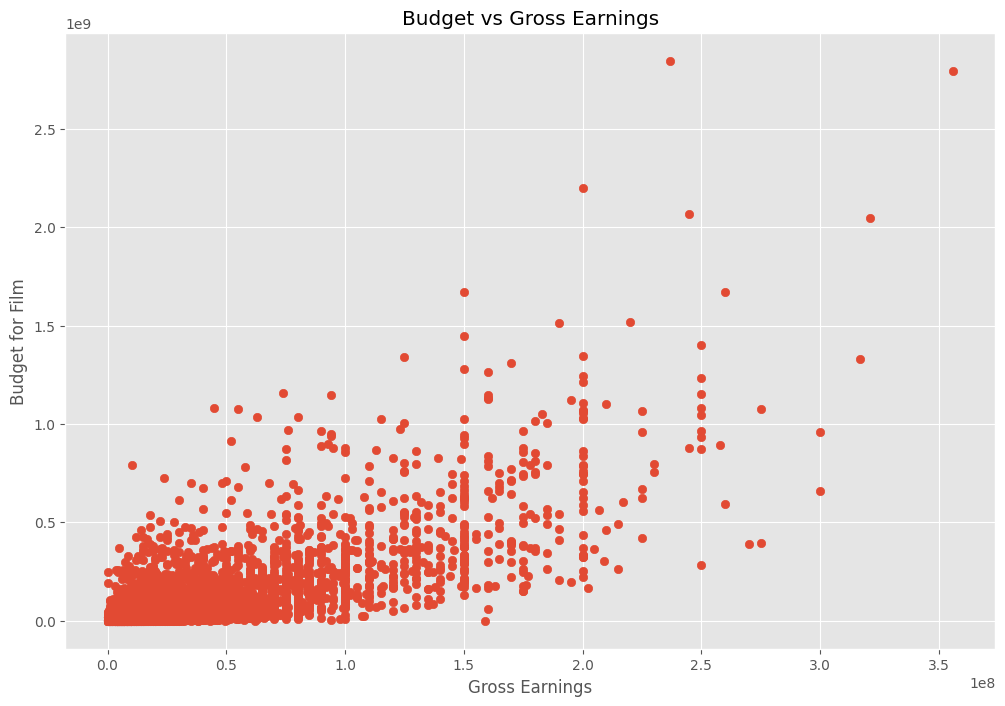

In [91]:
# Scatter plot with budget vs gross

plt.scatter(x=df['budget'], y=df['gross'])
plt.title('Budget vs Gross Earnings')
plt.xlabel('Gross Earnings')
plt.ylabel('Budget for Film')
plt.show()

In [92]:
df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,CorrectYear
5445,Avatar,PG-13,Action,2009,"December 18, 2009 (United States)",7.8,1100000.0,James Cameron,James Cameron,Sam Worthington,United States,237000000,2847246203,Twentieth Century Fox,162.0,2009
7445,Avengers: Endgame,PG-13,Action,2019,"April 26, 2019 (United States)",8.4,903000.0,Anthony Russo,Christopher Markus,Robert Downey Jr.,United States,356000000,2797501328,Marvel Studios,181.0,2019
3045,Titanic,PG-13,Drama,1997,"December 19, 1997 (United States)",7.8,1100000.0,James Cameron,James Cameron,Leonardo DiCaprio,United States,200000000,2201647264,Twentieth Century Fox,194.0,1997
6663,Star Wars: Episode VII - The Force Awakens,PG-13,Action,2015,"December 18, 2015 (United States)",7.8,876000.0,J.J. Abrams,Lawrence Kasdan,Daisy Ridley,United States,245000000,2069521700,Lucasfilm,138.0,2015
7244,Avengers: Infinity War,PG-13,Action,2018,"April 27, 2018 (United States)",8.4,897000.0,Anthony Russo,Christopher Markus,Robert Downey Jr.,United States,321000000,2048359754,Marvel Studios,149.0,2018


### Let's Start Looking at Correlation

<Axes: xlabel='budget', ylabel='gross'>

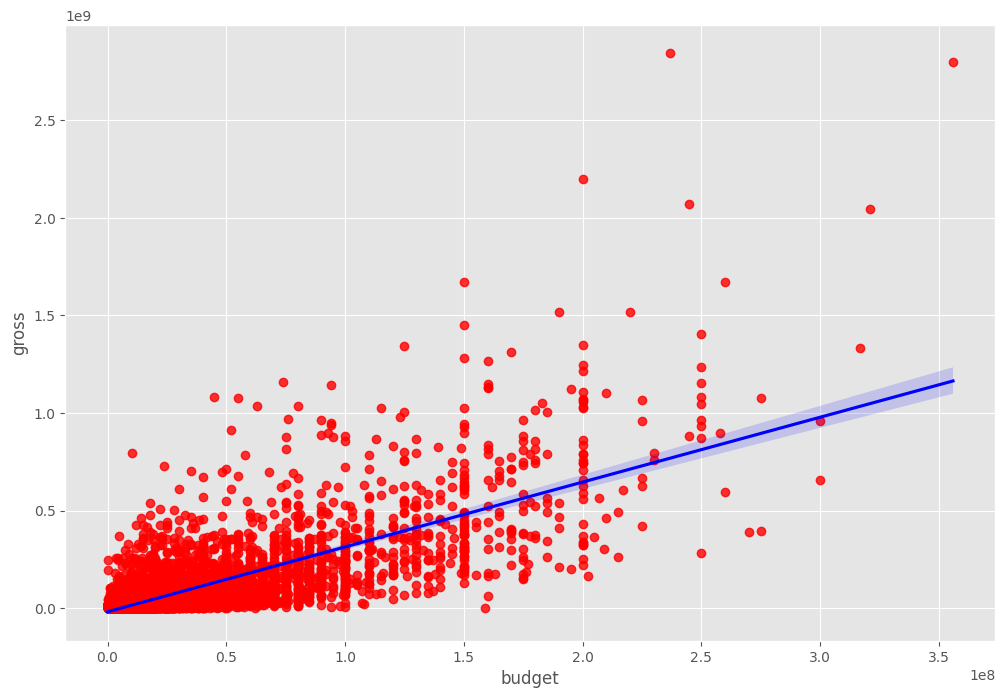

In [77]:
# Plot budget vs gross using seaborn

sns.regplot(x='budget', y='gross', data = df, scatter_kws={'color': 'red'}, line_kws={'color':'blue'})

In [78]:
df.corr(method='pearson', numeric_only=True)  #pearson, kendall, spearman
# Notice High correlation betweeen budget and gross

,year,score,votes,budget,gross,runtime
year,1.000000,0.098013,0.222573,0.320509,0.259504,0.120662
score,0.098013,1.000000,0.409157,0.060760,0.185563,0.399407
votes,0.222573,0.409157,1.000000,0.479326,0.632120,0.309151
budget,0.320509,0.060760,0.479326,1.000000,0.752049,0.303730
gross,0.259504,0.185563,0.632120,0.752049,1.000000,0.244380
runtime,0.120662,0.399407,0.309151,0.303730,0.244380,1.000000


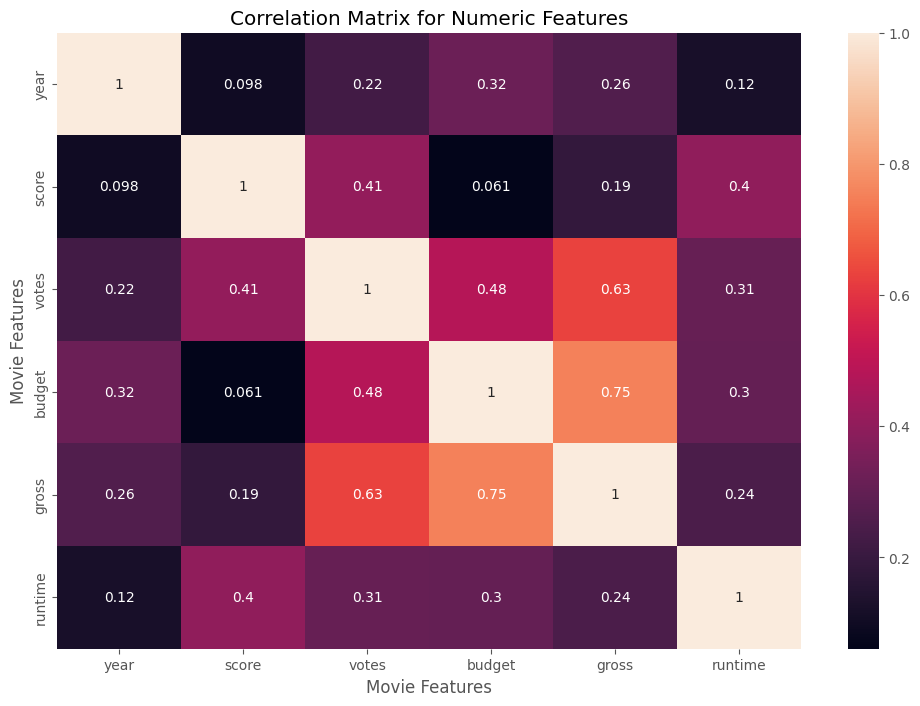

In [79]:
correlation_matrix = df.corr(method='pearson', numeric_only=True)
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix for Numeric Features')
plt.xlabel('Movie Features')
plt.ylabel('Movie Features')
plt.show()

In [80]:
df_numerized = df.copy()  # make an independent copy

for col in df_numerized.columns:
    if df_numerized[col].dtype == 'object' or df_numerized[col].dtype.name == 'category':
        df_numerized[col] = df_numerized[col].astype('category').cat.codes

df_numerized.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,CorrectYear
5445,533,5,0,2009,696,7.8,1100000.0,1155,1778,2334,55,237000000,2847246203,2253,162.0,29
7445,535,5,0,2019,183,8.4,903000.0,162,743,2241,55,356000000,2797501328,1606,181.0,39
3045,6896,5,6,1997,704,7.8,1100000.0,1155,1778,1595,55,200000000,2201647264,2253,194.0,17
6663,5144,5,0,2015,698,7.8,876000.0,1125,2550,524,55,245000000,2069521700,1540,138.0,35
7244,536,5,0,2018,192,8.4,897000.0,162,743,2241,55,321000000,2048359754,1606,149.0,38


In [81]:
df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,CorrectYear
5445,Avatar,PG-13,Action,2009,"December 18, 2009 (United States)",7.8,1100000.0,James Cameron,James Cameron,Sam Worthington,United States,237000000,2847246203,Twentieth Century Fox,162.0,2009
7445,Avengers: Endgame,PG-13,Action,2019,"April 26, 2019 (United States)",8.4,903000.0,Anthony Russo,Christopher Markus,Robert Downey Jr.,United States,356000000,2797501328,Marvel Studios,181.0,2019
3045,Titanic,PG-13,Drama,1997,"December 19, 1997 (United States)",7.8,1100000.0,James Cameron,James Cameron,Leonardo DiCaprio,United States,200000000,2201647264,Twentieth Century Fox,194.0,1997
6663,Star Wars: Episode VII - The Force Awakens,PG-13,Action,2015,"December 18, 2015 (United States)",7.8,876000.0,J.J. Abrams,Lawrence Kasdan,Daisy Ridley,United States,245000000,2069521700,Lucasfilm,138.0,2015
7244,Avengers: Infinity War,PG-13,Action,2018,"April 27, 2018 (United States)",8.4,897000.0,Anthony Russo,Christopher Markus,Robert Downey Jr.,United States,321000000,2048359754,Marvel Studios,149.0,2018


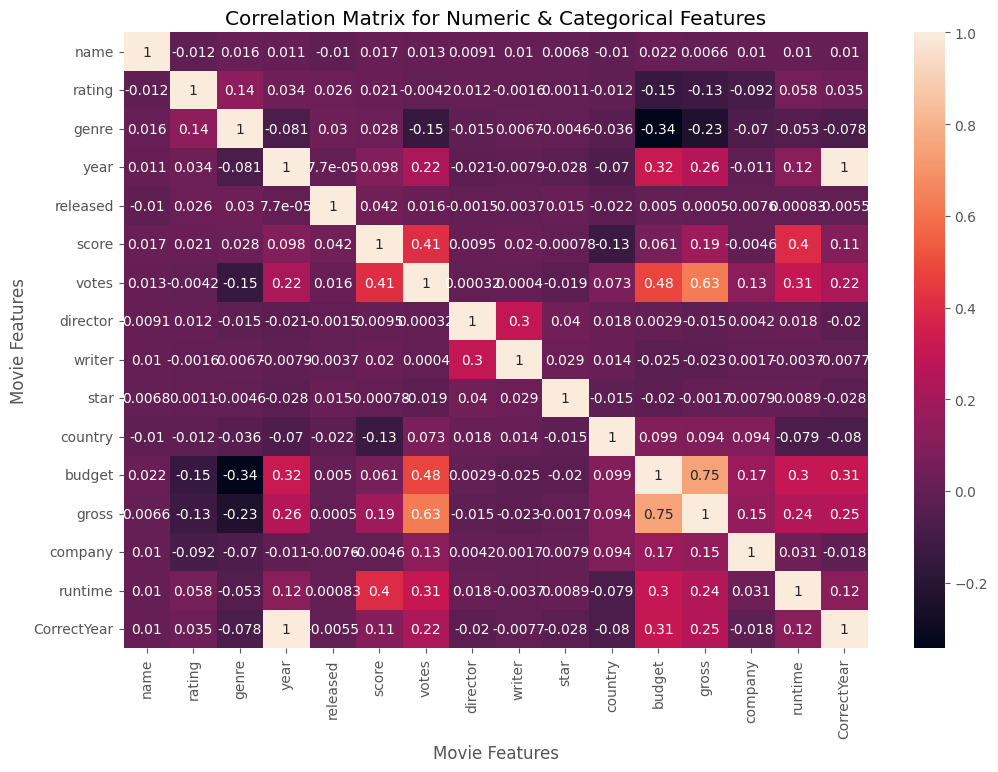

In [83]:
correlation_matrix = df_numerized.corr(method='pearson', numeric_only=True)
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix for Numeric & Categorical Features')
plt.xlabel('Movie Features')
plt.ylabel('Movie Features')
plt.show()

In [84]:
corr_matrix = df_numerized.corr()
corr_pairs = corr_matrix.unstack()
corr_pairs

name         name           1.000000
             rating        -0.012206
             genre          0.016355
             year           0.011453
             released      -0.010480
             score          0.017105
             votes          0.013056
             director       0.009079
             writer         0.009985
             star           0.006844
             country       -0.010359
             budget         0.021690
             gross          0.006601
             company        0.010373
             runtime        0.010335
             CorrectYear    0.010225
rating       name          -0.012206
             rating         1.000000
             genre          0.136127
             year           0.033801
             released       0.025526
             score          0.021087
             votes         -0.004217
             director       0.011951
             writer        -0.001610
             star           0.001063
             country       -0.011793
 

In [85]:
sorted_pairs = corr_pairs.sort_values()
sorted_pairs

genre        budget        -0.343745
budget       genre         -0.343745
gross        genre         -0.233385
genre        gross         -0.233385
rating       budget        -0.149056
budget       rating        -0.149056
votes        genre         -0.145291
genre        votes         -0.145291
country      score         -0.134427
score        country       -0.134427
rating       gross         -0.130747
gross        rating        -0.130747
company      rating        -0.092284
rating       company       -0.092284
genre        year          -0.081261
year         genre         -0.081261
country      CorrectYear   -0.080482
CorrectYear  country       -0.080482
runtime      country       -0.079230
country      runtime       -0.079230
genre        CorrectYear   -0.078210
CorrectYear  genre         -0.078210
company      genre         -0.070032
genre        company       -0.070032
year         country       -0.069590
country      year          -0.069590
runtime      genre         -0.052719
g

In [89]:
high_corr = sorted_pairs[(sorted_pairs) > 0.5]
high_corr

# Votes and budget have the highest correlation to gross earnings. 
# Company has low correlation.

gross        votes          0.632120
votes        gross          0.632120
gross        budget         0.752049
budget       gross          0.752049
year         CorrectYear    0.996397
CorrectYear  year           0.996397
director     director       1.000000
votes        votes          1.000000
released     released       1.000000
score        score          1.000000
rating       rating         1.000000
name         name           1.000000
genre        genre          1.000000
year         year           1.000000
budget       budget         1.000000
country      country        1.000000
writer       writer         1.000000
star         star           1.000000
company      company        1.000000
gross        gross          1.000000
runtime      runtime        1.000000
CorrectYear  CorrectYear    1.000000
dtype: float64